# Urban Heat Island Prediction

The objective of this notebook is to build a machine learning model to predict urban heat island (UHI) hotspots in a city and the intensity of this effect.

## Load In Dependencies

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
import glob
from tqdm import tqdm



## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

#### The Sentinel-2 Data
To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values.

There are two common methods to extract band values from Sentinel-2 data:

- Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.

- Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.

#### The Landsat Data
To obtain the Landsat temperature data, we also created a GeoTiff image to exctrat the temperature of interest.

#### The Building Footprint Data
These data were exctracted from NYC Open Data : https://data.cityofnewyork.us/City-Government/Building-Footprints-Map-/3g6p-4u5s
This CSV file contains the coordinates of all the buildings in Manhattan and the Bronx, associated with their elevation.


### Downloading GeoTIFF Image of Sentinel-2 to visualize it

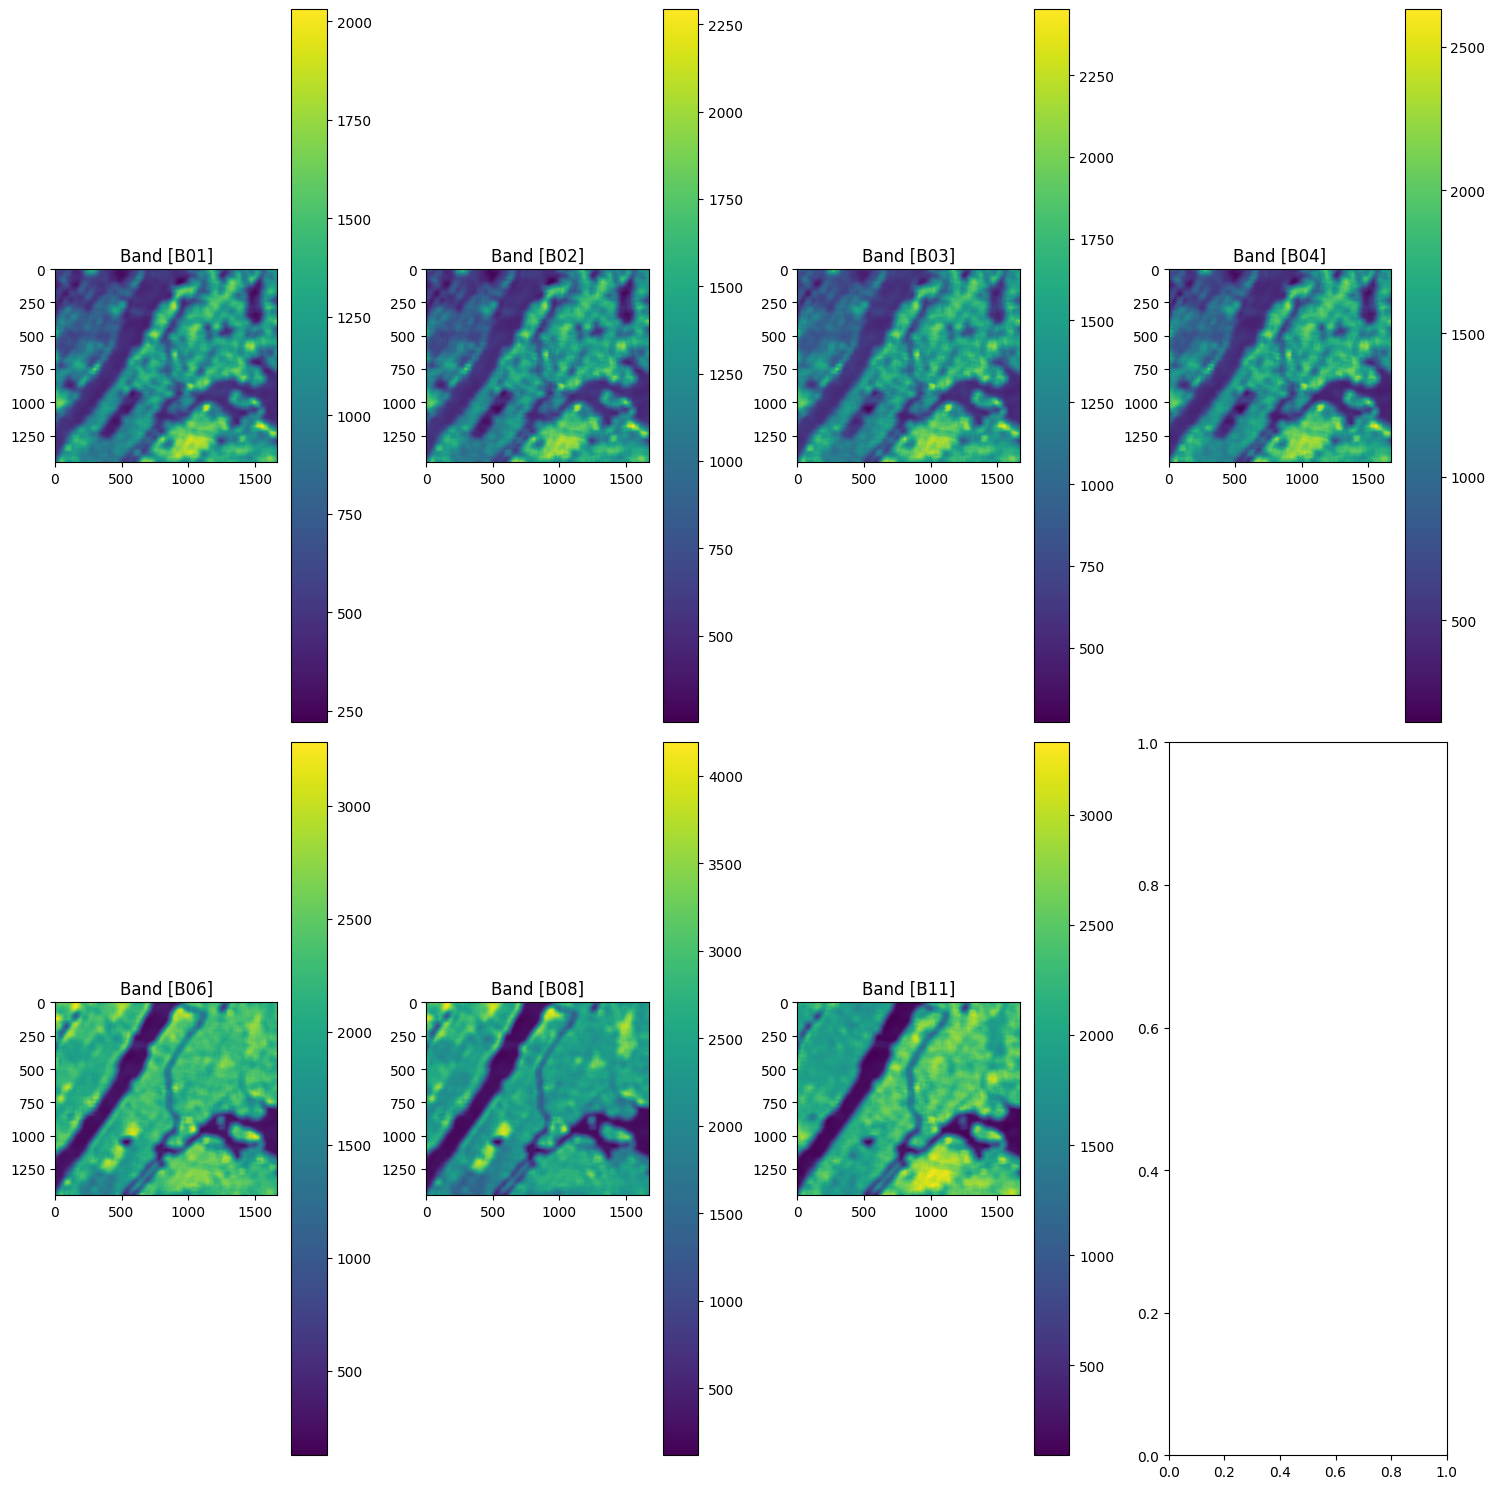

In [3]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "S2_sample_data_buffer_1000.tiff"  #"S2_sample_median.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B02]
    band3 = src1.read(3)  # Band [B03]
    band4 = src1.read(4)  # Band [B04]
    band5 = src1.read(5)  # Band [B06]
    band6 = src1.read(6)  # Band [B08]
    band7 = src1.read(7)  # Band [B11]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 4, figsize=(15, 15))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B02)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B02]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B03)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B03]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B04)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B04]')
fig.colorbar(im4, ax=axes[3])

# Plot the fifth band (B06)
im5 = axes[4].imshow(band5, cmap='viridis')
axes[4].set_title('Band [B06]')
fig.colorbar(im5, ax=axes[4])

# Plot the sixth band (B08)
im6 = axes[5].imshow(band6, cmap='viridis')
axes[5].set_title('Band [B08]')
fig.colorbar(im6, ax=axes[5])

# Plot the seventh band (B11)
im7 = axes[6].imshow(band7, cmap='viridis')
axes[6].set_title('Band [B11]')
fig.colorbar(im7, ax=axes[6])

plt.tight_layout()
plt.show()





### Extracting Band Values from the GeoTIFF Image


In [4]:
tiff_pathes = ['S2_sample_median___.tiff','S2_sample_data_buffer_50.tiff', 'S2_sample_data_buffer_100.tiff',
            'S2_sample_data_buffer_150.tiff','S2_sample_data_buffer_200.tiff','S2_sample_data_buffer_250.tiff',
            'S2_sample_data_buffer_300.tiff','S2_sample_data_buffer_350.tiff', 'S2_sample_data_buffer_400.tiff',
            'S2_sample_data_buffer_450.tiff', 'S2_sample_data_buffer_500.tiff','S2_sample_data_buffer_600.tiff',
            'S2_sample_data_buffer_700.tiff','S2_sample_data_buffer_800.tiff', 'S2_sample_data_buffer_900.tiff',
            'S2_sample_data_buffer_1000.tiff']

# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.
def map_satellite_data(tiff_pathes, csv_path):
    
    # Read the Excel file using pandas
    df_coord = pd.read_csv(csv_path)
    latitudes = df_coord['Latitude'].values
    longitudes = df_coord['Longitude'].values
    
    # Create a DataFrame to store the band values
    df = pd.DataFrame()

    for tiff_path in tiff_pathes :

        print(tiff_path)
        name = tiff_path.split(".")[0]
        extension = "_".join(name.split("_")[-2:])

        # Load the GeoTIFF data
        data = rxr.open_rasterio(tiff_path)
        tiff_crs = data.rio.crs

        # 3. Convert lat/long to the GeoTIFF's CRSy
        # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
        proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
        proj_tiff = Proj(tiff_crs)
        
        # Create a transformer object
        transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

        B01_values = []
        B02_values = []
        B03_values = []
        B04_values = []
        B06_values = []
        B08_values = []
        B11_values = []

    # Iterate over the latitudes and longitudes, and extract the corresponding band values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

            B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
            B01_values.append(B01_value)

            B02_value = data.sel(x=lon, y=lat,  band=2, method="nearest").values
            B02_values.append(B02_value)
            
            B03_value = data.sel(x=lon, y=lat,  band=3, method="nearest").values
            B03_values.append(B03_value)
            
            B04_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
            B04_values.append(B04_value)
            
            B06_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
            B06_values.append(B06_value)
            
            B08_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
            B08_values.append(B08_value)
        
            B11_value = data.sel(x=lon, y=lat, band=7, method="nearest").values
            B11_values.append(B11_value)
            

        # Create a DataFrame to store the band values
        df['B01_'+extension] = B01_values
        df['B02_'+extension] = B02_values
        df['B03_'+extension] = B03_values
        df['B04_'+extension] = B04_values
        df['B06_'+extension] = B06_values
        df['B08_'+extension] = B08_values
        df['B11_'+extension] = B11_values

        df['NDVI_'+extension] = (df['B08_'+extension] - df['B04_'+extension]) / (df['B08_'+extension] + df['B04_'+extension])
        df['NDBI_'+extension] = (df['B11_'+extension] - df['B08_'+extension]) / (df['B11_'+extension] + df['B08_'+extension])
        df['NDWI_'+extension] = (df['B03_'+extension] - df['B08_'+extension]) / (df['B03_'+extension] + df['B08_'+extension])
        df['NDVI_'+extension] = df['NDVI_'+extension].replace([np.inf, -np.inf], np.nan)
        df['NDBI_'+extension] = df['NDBI_'+extension].replace([np.inf, -np.inf], np.nan)
        df['NDWI_'+extension] = df['NDWI_'+extension].replace([np.inf, -np.inf], np.nan)

    return df

In [5]:
# Mapping satellite data with training data.
satellite_data = map_satellite_data(tiff_pathes, 'Training_data_uhi_index.csv')

## 1min per file - 16 files

S2_sample_median___.tiff


Mapping values: 100%|██████████| 11229/11229 [01:14<00:00, 149.90it/s]


S2_sample_data_buffer_50.tiff


Mapping values: 100%|██████████| 11229/11229 [03:45<00:00, 49.88it/s]


S2_sample_data_buffer_100.tiff


Mapping values: 100%|██████████| 11229/11229 [03:48<00:00, 49.18it/s]


S2_sample_data_buffer_150.tiff


Mapping values: 100%|██████████| 11229/11229 [01:51<00:00, 100.88it/s]


S2_sample_data_buffer_200.tiff


Mapping values: 100%|██████████| 11229/11229 [02:12<00:00, 84.47it/s] 


S2_sample_data_buffer_250.tiff


Mapping values: 100%|██████████| 11229/11229 [01:55<00:00, 97.01it/s] 


S2_sample_data_buffer_300.tiff


Mapping values: 100%|██████████| 11229/11229 [04:39<00:00, 40.18it/s]


S2_sample_data_buffer_350.tiff


Mapping values: 100%|██████████| 11229/11229 [02:37<00:00, 71.10it/s] 


S2_sample_data_buffer_400.tiff


Mapping values: 100%|██████████| 11229/11229 [01:11<00:00, 157.58it/s]


S2_sample_data_buffer_450.tiff


Mapping values: 100%|██████████| 11229/11229 [01:12<00:00, 155.70it/s]


S2_sample_data_buffer_500.tiff


Mapping values: 100%|██████████| 11229/11229 [01:32<00:00, 121.06it/s]


S2_sample_data_buffer_600.tiff


Mapping values: 100%|██████████| 11229/11229 [01:11<00:00, 157.04it/s]


S2_sample_data_buffer_700.tiff


Mapping values: 100%|██████████| 11229/11229 [01:27<00:00, 127.96it/s]


S2_sample_data_buffer_800.tiff


Mapping values: 100%|██████████| 11229/11229 [01:23<00:00, 135.08it/s]


S2_sample_data_buffer_900.tiff


Mapping values: 100%|██████████| 11229/11229 [01:18<00:00, 143.59it/s]


S2_sample_data_buffer_1000.tiff


Mapping values: 100%|██████████| 11229/11229 [01:17<00:00, 144.03it/s]


### Extracting LST Temperature data

In [6]:
### Adding the temeprature data from LST
def map_lst_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    lst_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        lst_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        lst_values.append(lst_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['LST'] = lst_values
    
    return df


lst_data = map_lst_data('Landsat_LST.tiff', 'Training_data_uhi_index.csv')
lst_data


Mapping values: 100%|██████████| 11229/11229 [00:09<00:00, 1130.60it/s]


,LST
0,38.393941100000006
1,38.393941100000006
2,37.78553354000002
3,37.78553354000002
4,37.35828104000001
...,...
11224,30.29323370000003
11225,30.29323370000003
11226,30.44020856000003
11227,30.44020856000003


### Exctracting data from Building Footprint NYC Open data CSV

In [7]:
### Creating the buildings dataframe

from sklearn.neighbors import BallTree
from shapely import wkt
import geopandas as gpd

df_init = pd.read_csv('Building_Footprints_NYC_Open_data_20250319.csv')

# 0. Metrre au format geo
df = df_init[['the_geom', 'HEIGHTROOF' ]]
df['the_geom']= df['the_geom'].apply(wkt.loads)

# 1. Créer un GeoDataFrame avec le CRS correct
gdf = gpd.GeoDataFrame(df, geometry=df['the_geom'], crs="EPSG:4326")

# 2. Calculer les centroïdes dans EPSG:4326  + les usrfaces en metres dans EPSG:3857
gdf['centroid'] = gdf.centroid

gdf_projected_meters = gdf.to_crs("EPSG:3857")
gdf['area_meters'] = gdf_projected_meters.geometry.area

gdf['centroid_x'] = gdf.centroid.x
gdf['centroid_y'] = gdf.centroid.y

gdf = gdf.rename(columns={"centroid_x": "Longitude", "centroid_y": "Latitude"})


# 3. conversion feet en metres
gdf['HEIGHTROOF'] = gdf['HEIGHTROOF']* 0.3048


# 4. Frontières de nyc
lower_left = (40.75, -74.01)  # Latitude, Longitude
upper_right = (40.88, -73.86)

gdf_nyc = gdf[     (gdf['Latitude'] >= lower_left[0]) & (gdf['Latitude'] <= upper_right[0]) &
                   (gdf['Longitude'] >= lower_left[1]) & (gdf['Longitude'] <= upper_right[1])    ]

# 5. Calcul du volume
gdf_nyc['Volume'] = gdf_nyc['area_meters'] * gdf_nyc['HEIGHTROOF'] # calcul du volume en feet cube

# 6. df final
gdf_final = gdf_nyc[['Longitude','Latitude','area_meters','HEIGHTROOF', 'Volume']]




In [8]:
def map_building_data(df_buildings, csv_path, list_radius):
    """
    Calcule la somme des volumes et des aires des bâtiments dans un rayon spécifié autour d'un point.

    Args:
        df: DataFrame contenant les données des bâtiments (latitude, longitude, area_feet, Volume).
        point_coords: Tuple (latitude, longitude) du point central.
        radius_meters: Rayon de recherche en mètres.

    Returns:
        Un tuple contenant (sum_volume, sum_area).
    """
    
    df_points = pd.read_csv(csv_path)

    # 1. Convertir les coordonnées en radians
    df_buildings[['lat_rad', 'lon_rad']] = np.radians(df_buildings[['Latitude', 'Longitude']])
    df_points[['lat_rad', 'lon_rad']] = np.radians(df_points[['Latitude', 'Longitude']])

    # 2. Créer un BallTree pour les bâtiments
    tree = BallTree(df_buildings[['lat_rad', 'lon_rad']], metric='haversine')
    
    earth_radius = 6371000

    for radius_meters in list_radius:

        # 3. Convertir le rayon en radians
        radius_rad = radius_meters / earth_radius
        buffer_area = np.pi * radius_meters**2

        # 4. Trouver les indices des bâtiments voisins pour chaque point et calculer les sommes
        sum_volumes = []
        sum_areas = []

        for point_rad in df_points[['lat_rad', 'lon_rad']].values: # pour chaque point
            indices_voisins = tree.query_radius([point_rad], r=radius_rad)[0]
            sum_volumes.append(df_buildings['Volume'].iloc[indices_voisins].sum() / buffer_area)
            sum_areas.append(df_buildings['area_meters'].iloc[indices_voisins].sum() / buffer_area)


        # 5. Créer un DataFrame avec les sommes et les coordonnées des points

        df_points['sum_volume_'+ str(radius_meters)] = sum_volumes
        df_points['sum_area_' + str(radius_meters)] = sum_areas


    sum_columns = [col for col in df_points.columns if col.startswith('sum')]

    return df_points[sum_columns]

In [9]:
list_radius = [50,100,150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]
building_data = map_building_data(df_buildings = gdf_final, csv_path='Training_data_uhi_index.csv', list_radius = list_radius)

building_data

,sum_volume_50,sum_area_50,sum_volume_100,sum_area_100,sum_volume_150,sum_area_150,sum_volume_200,sum_area_200,sum_volume_250,sum_area_250,...,sum_volume_600,sum_area_600,sum_volume_700,sum_area_700,sum_volume_800,sum_area_800,sum_volume_900,sum_area_900,sum_volume_1000,sum_area_1000
0,3.075689,0.203869,12.707957,0.608042,9.501551,0.522346,8.154091,0.459399,8.627258,0.507129,...,7.180438,0.469913,7.708661,0.473045,7.770018,0.483904,7.575328,0.480118,7.488212,0.503865
1,3.075689,0.203869,12.885464,0.618580,9.473605,0.519290,8.182834,0.460176,8.466504,0.499629,...,7.176731,0.471009,7.352187,0.464350,7.688449,0.478684,7.593085,0.481639,7.468213,0.502938
2,3.075689,0.203869,13.031075,0.625147,9.625736,0.532421,8.256221,0.459471,8.042062,0.502237,...,7.076756,0.467667,7.274513,0.455573,7.702242,0.479486,7.565041,0.481006,7.448802,0.501068
3,3.315583,0.244585,9.904020,0.421403,9.615599,0.521297,8.256221,0.459471,7.869105,0.484906,...,7.047003,0.464705,7.179260,0.453358,7.776295,0.481357,7.591924,0.481995,7.471626,0.504380
4,16.239512,0.468464,10.004472,0.430318,10.046661,0.545642,8.801408,0.523726,7.902676,0.488340,...,7.081902,0.468611,7.125562,0.450150,7.770352,0.480824,7.489232,0.478420,7.489117,0.505363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062140,0.010789,...,7.630829,0.180313,8.047021,0.207557,9.016879,0.243757,10.134310,0.279167,11.741179,0.314502
11225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062140,0.010789,...,7.639951,0.180865,8.035538,0.207039,9.048777,0.244460,10.160431,0.280595,11.764040,0.314715
11226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062140,0.010789,...,7.649368,0.181418,8.053058,0.207260,9.063811,0.244352,10.269171,0.282511,11.692084,0.312881
11227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062140,0.010789,...,7.614912,0.180997,8.054346,0.207295,9.065834,0.244476,10.272837,0.282548,11.688200,0.312613


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [10]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [11]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,satellite_data)
uhi_data = combine_two_datasets(uhi_data,lst_data)
uhi_data = combine_two_datasets(uhi_data,building_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01__,B02__,B03__,B04__,B06__,B08__,...,sum_volume_600,sum_area_600,sum_volume_700,sum_area_700,sum_volume_800,sum_area_800,sum_volume_900,sum_area_900,sum_volume_1000,sum_area_1000
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,...,7.180438,0.469913,7.708661,0.473045,7.770018,0.483904,7.575328,0.480118,7.488212,0.503865
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,...,7.176731,0.471009,7.352187,0.464350,7.688449,0.478684,7.593085,0.481639,7.468213,0.502938
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,646.0,823.0,777.0,1883.0,2241.0,...,7.076756,0.467667,7.274513,0.455573,7.702242,0.479486,7.565041,0.481006,7.448802,0.501068
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,625.0,766.0,741.5,1883.0,2200.0,...,7.047003,0.464705,7.179260,0.453358,7.776295,0.481357,7.591924,0.481995,7.471626,0.504380
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,659.5,763.0,708.5,1783.0,2161.0,...,7.081902,0.468611,7.125562,0.450150,7.770352,0.480824,7.489232,0.478420,7.489117,0.505363


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [388]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B02', 'B03',
       'B04', 'B06', 'B08', 'B11', 'B01_BUFFER50', 'B02_BUFFER50',
       'B03_BUFFER50', 'B04_BUFFER50', 'B06_BUFFER50', 'B08_BUFFER50',
       'B11_BUFFER50', 'NDVI', 'NDBI', 'NDWI', 'NDVI_BUFFER50',
       'NDBI_BUFFER50', 'NDWI_BUFFER50', 'LST']  #['B01','B02', 'B03','B04','B06','B08','NDVI', 'NDBI', 'NDWI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head() 


,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B06,B08,...,B06_BUFFER50,B08_BUFFER50,B11_BUFFER50,NDVI,NDBI,NDWI,NDVI_BUFFER50,NDBI_BUFFER50,NDWI_BUFFER50,LST
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,...,1785.675000,1842.043750,1851.293750,0.206057,-0.011038,-0.226649,0.199442,0.002505,-0.235991,38.393941
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,...,1799.314815,1868.882716,1820.765432,0.206057,-0.011038,-0.226649,0.224416,-0.013041,-0.257600,38.393941
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,646.0,823.0,777.0,1883.0,2241.0,...,1782.402597,1866.759740,1765.512987,0.485089,-0.182898,-0.462794,0.253487,-0.027874,-0.280003,37.785534
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,625.0,766.0,741.5,1883.0,2200.0,...,1819.525974,1925.564935,1765.129870,0.495835,-0.173959,-0.483479,0.269724,-0.043470,-0.292449,37.785534
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,659.5,763.0,708.5,1783.0,2161.0,...,1830.935897,1948.217949,1770.705128,0.506186,-0.143840,-0.478112,0.276951,-0.047732,-0.293313,37.358281


In [12]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)
uhi_data

,Longitude,Latitude,datetime,UHI Index,B01__,B02__,B03__,B04__,B06__,B08__,...,sum_volume_600,sum_area_600,sum_volume_700,sum_area_700,sum_volume_800,sum_area_800,sum_volume_900,sum_area_900,sum_volume_1000,sum_area_1000
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,...,7.180438,0.469913,7.708661,0.473045,7.770018,0.483904,7.575328,0.480118,7.488212,0.503865
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,841.5,1053.0,1155.0,1206.0,1660.5,1832.0,...,7.176731,0.471009,7.352187,0.464350,7.688449,0.478684,7.593085,0.481639,7.468213,0.502938
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,646.0,823.0,777.0,1883.0,2241.0,...,7.076756,0.467667,7.274513,0.455573,7.702242,0.479486,7.565041,0.481006,7.448802,0.501068
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,625.0,766.0,741.5,1883.0,2200.0,...,7.047003,0.464705,7.179260,0.453358,7.776295,0.481357,7.591924,0.481995,7.471626,0.504380
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,659.5,763.0,708.5,1783.0,2161.0,...,7.081902,0.468611,7.125562,0.450150,7.770352,0.480824,7.489232,0.478420,7.489117,0.505363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,462.5,491.0,725.5,501.0,2612.0,3152.0,...,7.630829,0.180313,8.047021,0.207557,9.016879,0.243757,10.134310,0.279167,11.741179,0.314502
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,462.5,506.5,741.5,551.5,2612.0,3572.0,...,7.639951,0.180865,8.035538,0.207039,9.048777,0.244460,10.160431,0.280595,11.764040,0.314715
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,462.5,506.5,741.5,551.5,2612.0,3572.0,...,7.649368,0.181418,8.053058,0.207260,9.063811,0.244352,10.269171,0.282511,11.692084,0.312881
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,462.5,506.5,741.5,551.5,2612.0,3572.0,...,7.614912,0.180997,8.054346,0.207295,9.065834,0.244476,10.272837,0.282548,11.688200,0.312613


## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [13]:
features = ['UHI Index'] + list(satellite_data.columns) + list(lst_data.columns) + list(building_data.columns)

print(features)

# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
uhi_data_features = uhi_data[features]


['UHI Index', 'B01__', 'B02__', 'B03__', 'B04__', 'B06__', 'B08__', 'B11__', 'NDVI__', 'NDBI__', 'NDWI__', 'B01_buffer_50', 'B02_buffer_50', 'B03_buffer_50', 'B04_buffer_50', 'B06_buffer_50', 'B08_buffer_50', 'B11_buffer_50', 'NDVI_buffer_50', 'NDBI_buffer_50', 'NDWI_buffer_50', 'B01_buffer_100', 'B02_buffer_100', 'B03_buffer_100', 'B04_buffer_100', 'B06_buffer_100', 'B08_buffer_100', 'B11_buffer_100', 'NDVI_buffer_100', 'NDBI_buffer_100', 'NDWI_buffer_100', 'B01_buffer_150', 'B02_buffer_150', 'B03_buffer_150', 'B04_buffer_150', 'B06_buffer_150', 'B08_buffer_150', 'B11_buffer_150', 'NDVI_buffer_150', 'NDBI_buffer_150', 'NDWI_buffer_150', 'B01_buffer_200', 'B02_buffer_200', 'B03_buffer_200', 'B04_buffer_200', 'B06_buffer_200', 'B08_buffer_200', 'B11_buffer_200', 'NDVI_buffer_200', 'NDBI_buffer_200', 'NDWI_buffer_200', 'B01_buffer_250', 'B02_buffer_250', 'B03_buffer_250', 'B04_buffer_250', 'B06_buffer_250', 'B08_buffer_250', 'B11_buffer_250', 'NDVI_buffer_250', 'NDBI_buffer_250', 'NDWI_b

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

### Feature Scaling 

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

In [17]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data_features.drop(columns=['UHI Index']).values
y = uhi_data_features['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)


# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train_columns = uhi_data_features.drop(columns=['UHI Index']).columns
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. We will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. </p>


In [18]:
### Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)
## Parameters found with GridSearch :
#n_estimators=200, min_samples_split= 5, min_samples_leaf= 1, max_samples= 1.0, max_features='log2', max_depth=30, random_state=42


### Testing on Training set
insample_predictions = model.predict(X_train)
Y_train = y_train.tolist()
print( 'r2_score :   ', r2_score(Y_train, insample_predictions))


### Testing on Test set
outsample_predictions = model.predict(X_test)
Y_test = y_test.tolist()
print('test :   ',r2_score(Y_test, outsample_predictions))


### Analyzing the features impact
feature_scores = pd.Series(model.feature_importances_, index=X_train_columns).sort_values(ascending=False)
feature_scores.to_csv('features scores.txt', index=True, header=True)
print(feature_scores)

r2_score :    0.9916342242218535
test :    0.9404707702309756
sum_volume_1000    0.238970
sum_area_900       0.055775
B11_buffer_1000    0.040770
sum_volume_700     0.035691
sum_volume_250     0.031521
                     ...   
B03_buffer_350     0.000487
B03_buffer_50      0.000478
B04__              0.000470
B02_buffer_150     0.000458
B02_buffer_400     0.000399
Length: 191, dtype: float64


In [16]:
### Cross validation to test the robustness of our model
from sklearn.model_selection import cross_val_score

model2 = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')

print(f"Scores : {scores}")
print(f"Score moyen : {np.mean(scores)}")

Scores : [0.92622343 0.93026448 0.92842473 0.92478772 0.92191324]
Score moyen : 0.9263227200500257


## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [19]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [20]:
# Mapping satellite data for submission.
satellite_data = map_satellite_data(tiff_pathes, 'Submission_template.csv')
lst_data = map_lst_data('Landsat_LST.tiff', 'Submission_template.csv')
building_data = map_building_data(gdf_final, 'Submission_template.csv', list_radius)

val_data = combine_two_datasets(satellite_data, lst_data)
val_data = combine_two_datasets(val_data, building_data)


S2_sample_median___.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 188.91it/s]


S2_sample_data_buffer_50.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 189.93it/s]


S2_sample_data_buffer_100.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 192.38it/s]


S2_sample_data_buffer_150.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 197.94it/s]


S2_sample_data_buffer_200.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 193.54it/s]


S2_sample_data_buffer_250.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 194.01it/s]


S2_sample_data_buffer_300.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 190.64it/s]


S2_sample_data_buffer_350.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 182.89it/s]


S2_sample_data_buffer_400.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 182.42it/s]


S2_sample_data_buffer_450.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 185.47it/s]


S2_sample_data_buffer_500.tiff


Mapping values: 100%|██████████| 1040/1040 [00:06<00:00, 164.24it/s]


S2_sample_data_buffer_600.tiff


Mapping values: 100%|██████████| 1040/1040 [00:06<00:00, 171.80it/s]


S2_sample_data_buffer_700.tiff


Mapping values: 100%|██████████| 1040/1040 [00:06<00:00, 153.32it/s]


S2_sample_data_buffer_800.tiff


Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 183.55it/s]


S2_sample_data_buffer_900.tiff


Mapping values: 100%|██████████| 1040/1040 [00:06<00:00, 159.57it/s]


S2_sample_data_buffer_1000.tiff


Mapping values: 100%|██████████| 1040/1040 [00:00<00:00, 1376.36it/s]


In [21]:
val_data.head()

,B01__,B02__,B03__,B04__,B06__,B08__,B11__,NDVI__,NDBI__,NDWI__,...,sum_volume_600,sum_area_600,sum_volume_700,sum_area_700,sum_volume_800,sum_area_800,sum_volume_900,sum_area_900,sum_volume_1000,sum_area_1000
0,805.5,511.5,609.5,523.5,2243.0,2367.0,1727.0,0.637779,-0.156326,-0.590459,...,21.119819,0.647167,20.121420,0.605612,18.669296,0.547198,17.424830,0.501714,15.155026,0.438145
1,1214.5,560.0,704.5,566.0,2617.0,3632.0,2116.5,0.730348,-0.263634,-0.675084,...,21.731055,0.664536,20.062301,0.610024,18.978010,0.553685,17.500368,0.502818,15.212990,0.439573
2,1061.0,886.5,1018.5,1155.0,1457.0,1462.0,1646.0,0.117310,0.059202,-0.178795,...,13.196828,0.381416,13.312438,0.381902,12.964845,0.373690,12.723510,0.370176,12.691479,0.373040
3,1191.0,1014.5,1030.0,1189.0,1958.5,1571.0,2393.5,0.138406,0.207466,-0.207997,...,22.579962,0.690509,20.786154,0.631253,19.247546,0.560068,16.975683,0.491650,15.333438,0.442041
4,1082.0,1251.0,1390.0,1293.5,2280.0,2936.0,2118.5,0.388344,-0.161737,-0.357374,...,16.376953,0.510869,16.336080,0.486199,16.020617,0.472231,15.813884,0.457589,14.384130,0.419344


In [22]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
features_val = [col for col in features if col != 'UHI Index']

submission_val_data=val_data.loc[:,features_val]
submission_val_data.head()

,B01__,B02__,B03__,B04__,B06__,B08__,B11__,NDVI__,NDBI__,NDWI__,...,sum_volume_600,sum_area_600,sum_volume_700,sum_area_700,sum_volume_800,sum_area_800,sum_volume_900,sum_area_900,sum_volume_1000,sum_area_1000
0,805.5,511.5,609.5,523.5,2243.0,2367.0,1727.0,0.637779,-0.156326,-0.590459,...,21.119819,0.647167,20.121420,0.605612,18.669296,0.547198,17.424830,0.501714,15.155026,0.438145
1,1214.5,560.0,704.5,566.0,2617.0,3632.0,2116.5,0.730348,-0.263634,-0.675084,...,21.731055,0.664536,20.062301,0.610024,18.978010,0.553685,17.500368,0.502818,15.212990,0.439573
2,1061.0,886.5,1018.5,1155.0,1457.0,1462.0,1646.0,0.117310,0.059202,-0.178795,...,13.196828,0.381416,13.312438,0.381902,12.964845,0.373690,12.723510,0.370176,12.691479,0.373040
3,1191.0,1014.5,1030.0,1189.0,1958.5,1571.0,2393.5,0.138406,0.207466,-0.207997,...,22.579962,0.690509,20.786154,0.631253,19.247546,0.560068,16.975683,0.491650,15.333438,0.442041
4,1082.0,1251.0,1390.0,1293.5,2280.0,2936.0,2118.5,0.388344,-0.161737,-0.357374,...,16.376953,0.510869,16.336080,0.486199,16.020617,0.472231,15.813884,0.457589,14.384130,0.419344


In [23]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [24]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [25]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [26]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963140
1,-73.971928,40.788875,0.963858
2,-73.967080,40.789080,0.966750
3,-73.972550,40.789082,0.966844
4,-73.969697,40.787953,0.962553


In [75]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission_final_all training set 300 esti.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>